# NOT USED ANYMORE


In [1]:
import os
import glob
import xml.etree.ElementTree as ET


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import RoIAlign
from torchvision import transforms
from ultralytics import YOLO

import random
import numpy as np

In [2]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
from PIL import Image


class ResizePad:
    def __init__(self,size=(256,128),fill=0):
        self.target_h, self.target_w = size
        self.fill = fill
    def __call__(self,img):
        orig_w, orig_h = img.size
        scale = min(self.target_w/orig_w, self.target_h/orig_h)
        new_w, new_h = int(orig_w * scale),int(orig_h*scale)

        img = img.resize((new_w,new_h), Image.BILINEAR)

        new_img = Image.new("RGB",(self.target_w,self.target_h),(self.fill,)*3)
        paste_x = (self.target_w-new_w)//2
        paste_y = (self.target_h-new_h)//2
        new_img.paste(img,(paste_x,paste_y))

        return new_img

In [4]:
class FolderGroupedBatchDataset:
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((256, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
        self.pid_to_paths = defaultdict(list)
        for pid in os.listdir(root_dir):
            pid_folder = os.path.join(root_dir, pid)
            if os.path.isdir(pid_folder):
                for fname in os.listdir(pid_folder):
                    if fname.endswith('.png'):
                        self.pid_to_paths[pid].append(os.path.join(pid_folder, fname))
        self.pids = list(self.pid_to_paths.keys())

    def sample(self, P, K):
        selected_pids = random.sample(self.pids, min(P, len(self.pids)))
        images, labels = [], []
        for pid in selected_pids:
            paths = self.pid_to_paths[pid]
            chosen = random.choices(paths, k=K) if len(paths) < K else random.sample(paths, K)
            for path in chosen:
                img = Image.open(path).convert("RGB")
                img = self.transform(img)
                images.append(img)
                labels.append(pid)
        return torch.stack(images), labels

In [5]:
class FolderGroupedBatchTrainingDataset:
    """
    Groups images by folder (person ID) for training only. Does not inherit from PyTorch Dataset
    because it's not accessed by index but by a custom sampling method.
    """
    def __init__(self, root_dir, transform=None):
        self.transform = transform or transforms.Compose([
            ResizePad((256, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

        self.pid_to_imgs = defaultdict(list)

        for pid in os.listdir(root_dir):
            folder = os.path.join(root_dir, pid)
            if not os.path.isdir(folder): continue

            for img_path in glob.glob(os.path.join(folder, '*.png')):
                if os.path.exists(img_path.replace('.png', '.xml')):
                    self.pid_to_imgs[pid].append(img_path)

        self.pids = [pid for pid, imgs in self.pid_to_imgs.items() if len(imgs) >= 2]

    def sample(self, P, K):
        """
        Sample a batch of P identities with K images each.
        Returns: images (tensor list), labels (list of pids)
        """
        assert len(self.pids) >= P, "Not enough unique IDs to sample."

        batch_pids = random.sample(self.pids, P)
        images = []
        labels = []
        for pid in batch_pids:
            img_paths = random.sample(self.pid_to_imgs[pid], min(K, len(self.pid_to_imgs[pid])))
            for path in img_paths:
                img = Image.open(path).convert('RGB')
                img = self.transform(img)
                images.append(img)
                labels.append(pid)
        return images, labels

In [6]:

# Not used anymore.
def batch_hard_triplet_loss(embeddings, labels, margin=1.0,device=torch.device('cpu')):
    embeddings = F.normalize(embeddings, dim=1)
    labels = torch.tensor([hash(x) for x in labels])  # hash to int
    pdist = 1 - torch.matmul(embeddings, embeddings.T)
    mask_pos = labels.unsqueeze(1) == labels.unsqueeze(0)
    mask_neg = ~mask_pos
    mask_pos = mask_pos.float().to(device)
    mask_neg = mask_neg.float().to(device)

    hardest_pos = (pdist * mask_pos.float().to(device)).max(dim=1)[0]
    hardest_neg = (pdist + mask_pos.float().to(device) * 10).min(dim=1)[0]
    loss = F.relu(hardest_pos - hardest_neg + margin)
    return loss.mean()

In [7]:
import torch
import torch.nn.functional as F

def pairwise_distances(embeddings):
    # Compute cosine distance matrix
    normed = F.normalize(embeddings, p=2, dim=1)
    sim_matrix = torch.matmul(normed, normed.T)
    dist_matrix = 1 - sim_matrix  # cosine distance
    return dist_matrix

def combined_triplet_loss(embeddings, labels, margin=1.0, alpha=0.5, device=torch.device('cpu')):
    """
    Args:
        embeddings: Tensor [N, D]
        labels: List[str] or Tensor of IDs (can be string)
        margin: Triplet margin
        alpha: Weight for hard vs mean loss. alpha=0.5 → 50% hard, 50% mean
    """
    # Convert string labels to integer indices
    if isinstance(labels, list) and isinstance(labels[0], str):
        label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
        labels = [label_to_index[label] for label in labels]
        labels = torch.tensor(labels, device=embeddings.device)
    elif isinstance(labels, list):
        labels = torch.tensor(labels, device=embeddings.device)
    else:
        labels = labels.to(embeddings.device)

    pairwise_dist = pairwise_distances(embeddings)
    N = embeddings.size(0)

    loss_hard = 0.0
    loss_mean = 0.0
    valid_triplets = 0

    for i in range(N):
        anchor_label = labels[i]
        dists = pairwise_dist[i]

        is_pos = (labels == anchor_label) & (torch.arange(N, device=embeddings.device) != i)
        is_neg = labels != anchor_label

        if torch.sum(is_pos) == 0 or torch.sum(is_neg) == 0:
            continue  # skip if no valid pairs

        # Hardest positive and negative
        hardest_pos = dists[is_pos].max()
        hardest_neg = dists[is_neg].min()
        hard_loss = F.relu(hardest_pos - hardest_neg + margin)

        # Mean-based variant
        mean_pos = dists[is_pos].mean()
        mean_neg = dists[is_neg].mean()
        mean_loss = F.relu(mean_pos - mean_neg + margin)

        # Combine
        loss = alpha * hard_loss + (1 - alpha) * mean_loss
        loss_hard += loss
        valid_triplets += 1

    if valid_triplets == 0:
        return torch.tensor(0.0, requires_grad=True, device=embeddings.device)

    return loss_hard / valid_triplets

In [14]:
class YOLOv11ReID(nn.Module):
    def __init__(self, yolo_weights='yolo11n.pt', emb_dim=128):
        super().__init__()
        yolo_model = YOLO(yolo_weights)



        self.backbone = nn.Sequential(
          yolo_model.model.model[0],
          yolo_model.model.model[1],
          yolo_model.model.model[2],
          yolo_model.model.model[3],
          yolo_model.model.model[4],
          yolo_model.model.model[5],
          yolo_model.model.model[6],
          )
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.max_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.2)

        self.fc = nn.Sequential(
            nn.Linear(self._get_feat_dim(), emb_dim, bias=False),
            nn.BatchNorm1d(emb_dim)
        )
        for param in self.backbone[:4].parameters():
          param.requires_grad = False


    def _get_feat_dim(self):
        x = torch.zeros((1, 3, 256, 128))
        with torch.no_grad():
            f = self.backbone(x)
            avg_feat = self.avg_pool(f)
            max_feat = self.max_pool(f)
            feat = (avg_feat+max_feat)/2
            return feat.flatten(1).shape[1]


    def forward(self, x):
        x = self.backbone(x)

        avg_feat = self.avg_pool(x)
        max_feat = self.max_pool(x)
        f = (avg_feat + max_feat) / 2
        f = f.flatten(1)
        f = self.dropout(f)
        emb = self.fc(f)
        return nn.functional.normalize(emb, dim=1)


In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import numpy as np
import torch.nn.functional as F

# Validation
@torch.no_grad()
def validate_similarity(model, dataset, device, P=5, K=5, inter_K=10):
    model.eval()
    total_intra, total_inter, count_intra, count_inter = 0.0, 0.0, 0, 0

    selected_pids = random.sample(dataset.pids, min(P, len(dataset.pids)))
    for pid in selected_pids:
        paths = dataset.pid_to_paths[pid]
        if len(paths) < 2:
            continue
        chosen = random.sample(paths, min(K, len(paths)))
        imgs = torch.stack([dataset.transform(Image.open(p).convert("RGB")) for p in chosen]).to(device)
        embs = F.normalize(model(imgs), dim=1)
        for i in range(len(embs)):
            for j in range(i + 1, len(embs)):
                total_intra += F.cosine_similarity(embs[i].unsqueeze(0), embs[j].unsqueeze(0)).item()
                count_intra += 1

        # Inter
        inter_paths = []
        for _ in range(inter_K):
            other_pid = random.choice([x for x in dataset.pids if x != pid])
            other_img = random.choice(dataset.pid_to_paths[other_pid])
            inter_paths.append(other_img)
        inter_imgs = torch.stack([dataset.transform(Image.open(p).convert("RGB")) for p in inter_paths]).to(device)
        inter_embs = F.normalize(model(inter_imgs), dim=1)
        for anchor in embs:
            for inter in inter_embs:
                total_inter += F.cosine_similarity(anchor.unsqueeze(0), inter.unsqueeze(0)).item()
                count_inter += 1

    avg_intra = total_intra / count_intra if count_intra else 0.0
    avg_inter = total_inter / count_inter if count_inter else 0.0
    return avg_intra, avg_inter

In [16]:
from torch.nn import TripletMarginLoss

device ='cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = YOLOv11ReID().to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-4)

cuda


In [17]:
import os
real_epoch = 0
restart = False
last_epoch = 1000

if restart == True:
    real_epoch= last_epoch
    base_dir = os.getcwd()
    model.load_state_dict(torch.load(os.path.join(base_dir, f"saved_model2/ReIDPooling_{real_epoch}.pth")))

In [ ]:
import csv

train_dataset = FolderGroupedBatchTrainingDataset('../data/dataset1')
val_val_dataset = FolderGroupedBatchDataset('../data/valid_dataset1')
tr_val_dataset = FolderGroupedBatchDataset('../data/dataset1')

csv_log = f"ReID/train_logv1_{real_epoch}.csv"
with open(csv_log, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "loss", "train_intra", "train_inter", "val_intra", "val_inter"])

for epoch in range(100000):
    model.train()
    imgs, labels = train_dataset.sample(P=16, K=4)
    imgs = torch.stack(imgs).to(device)
    imgs = imgs.to(device)
    embeddings = model(imgs)
    loss = combined_triplet_loss(embeddings, labels,device=device)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10==0:
        print(f"[Epoch {epoch+1}] Loss: {loss.item():.4f}")
    train_intra, train_inter = "",""
    val_intra, val_inter = "",""

    if (epoch + 1) % 100 == 0:
        train_intra, train_inter = validate_similarity(model, tr_val_dataset, device)
        val_intra, val_inter = validate_similarity(model, val_val_dataset, device)
        torch.save(model.state_dict(), 'saved_model2/'+f"ReIDPooling_{real_epoch+1}.pth")
        print(f"train_intra : {train_intra}, train_inter : {train_inter}")
        print(f"valid_intra : {val_intra}, valid_inter : {val_inter}")
    if (epoch+1) % 20 == 0:
        with open(csv_log, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([real_epoch+1, loss.item(), train_intra, train_inter, val_intra, val_inter])
    if (epoch+1) % 1000 == 0:
        torch.save(model.state_dict(), 'saved_model2/'+f"ReIDPooling_{real_epoch+1}.pth")
    real_epoch += 1


[Epoch 10] Loss: 1.1296
[Epoch 20] Loss: 1.1847
[Epoch 30] Loss: 1.1425
[Epoch 40] Loss: 1.1507
[Epoch 50] Loss: 1.1255
[Epoch 60] Loss: 1.1984
[Epoch 70] Loss: 1.1701
[Epoch 80] Loss: 1.1506
[Epoch 90] Loss: 1.1340
[Epoch 100] Loss: 1.0800
train_intra : 0.3581767901033163, train_inter : 0.13034183556586504
valid_intra : 0.3888949159346521, valid_inter : 0.1106650722231716
[Epoch 110] Loss: 1.1484
[Epoch 120] Loss: 1.1449
[Epoch 130] Loss: 1.1518
[Epoch 140] Loss: 1.1217
[Epoch 150] Loss: 1.1588
[Epoch 160] Loss: 1.1395
[Epoch 170] Loss: 1.1762
[Epoch 180] Loss: 1.1289
[Epoch 190] Loss: 1.1319
[Epoch 200] Loss: 1.1435
train_intra : 0.3461625491082668, train_inter : 0.1540770409218967
valid_intra : 0.3147452101111412, valid_inter : 0.15266986259445547
[Epoch 210] Loss: 1.1267
[Epoch 220] Loss: 1.1278
[Epoch 230] Loss: 1.1118
[Epoch 240] Loss: 1.1158
[Epoch 250] Loss: 1.1055
[Epoch 260] Loss: 1.0818
[Epoch 270] Loss: 1.1336
[Epoch 280] Loss: 1.1272
[Epoch 290] Loss: 1.1471
[Epoch 300] Lo

KeyboardInterrupt: 

In [ ]:
# print(model)

In [ ]:
torch.save(model, '/content/reid_modelv2.0.pth')

In [ ]:
torch.save(model.state_dict(), 'reid_model_state_dictv2.0.pth')

In [ ]:
@torch.no_grad()
def extract_features_ids(model, dataloader, device):
    model.eval()
    all_features = []
    all_ids = []

    for images, ids in tqdm(dataloader, desc="Extracting features"):
        images = images.to(device)
        emb = model(images)  # [B, 128]
        emb = F.normalize(emb, dim=1)  # cosine normalization

        all_features.append(emb.cpu())
        all_ids.extend(ids)  # assume ids are strings or ints

    features = torch.cat(all_features, dim=0)
    return features, all_ids

In [ ]:
import matplotlib.pyplot as plt
def compute_similarity_gaps(features, ids,show=False):
    sim_matrix = cosine_similarity(features.numpy())  # [N, N]
    N = len(ids)
    gaps = []

    for i in range(N):
        query_id = ids[i]
        sim_scores = sim_matrix[i]

        # exclude self
        sim_scores[i] = -np.inf

        # positive scores (same ID, not self)
        pos_mask = np.array([j != i and ids[j] == query_id for j in range(N)])
        neg_mask = np.array([ids[j] != query_id for j in range(N)])

        if not np.any(pos_mask) or not np.any(neg_mask):
            continue  # skip if no pos/neg samples

        best_pos = np.max(sim_scores[pos_mask])
        best_neg = np.max(sim_scores[neg_mask])

        gap = best_pos - best_neg
        gaps.append(gap)

    gaps = np.array(gaps)
    print(f"Avg similarity gap (pos - hardest neg): {np.mean(gaps):.4f}")
    print(f"% queries where positive > negative: {(gaps > 0).mean()*100:.2f}%")
    if(show):
        # Optional: visualize
        plt.hist(gaps, bins=40, color='blue', edgecolor='black')
        plt.title("Distribution of (best positive - hardest negative) similarity gaps")
        plt.xlabel("Similarity Gap")
        plt.ylabel("Number of queries")
        plt.grid(True)
        plt.show()

Avg similarity gap (pos - hardest neg): 0.1173
% queries where positive > negative: 94.56%


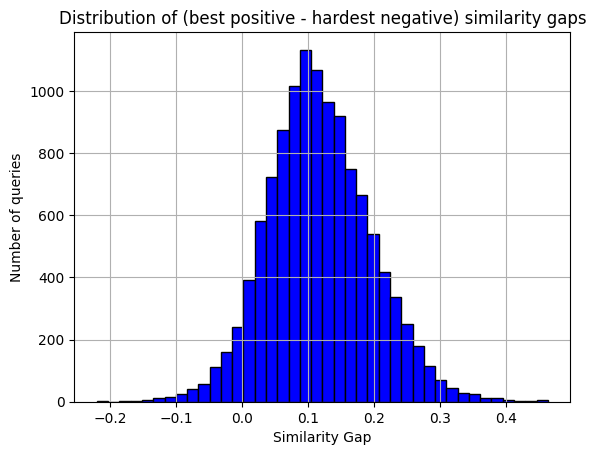

In [ ]:
features, ids = extract_features_ids(model, val_loader, device)
compute_similarity_gaps(features, ids, show=True)

In [ ]:
intra, inter = compute_intra_inter_similarity(features, ids)

Avg similarity (same ID):     0.2792
Avg similarity (different ID): 0.0508
